In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('train.csv')
data

KeyboardInterrupt: 

In [67]:

if torch.cuda.is_available():
    print("CUDA is available")
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))
print(torch.__version__)

CUDA is available
NVIDIA GeForce RTX 3050 Laptop GPU
2.5.1+cu118


In [ ]:
#%pip install cupy-cuda11x


Note: you may need to restart the kernel to use updated packages.


In [69]:
data= pd.read_csv('test.csv')

In [70]:
data = np.array(data)
#np.random.shuffle(data) #shuffling the data
m, n = data.shape
m,n

(28000, 784)

In [71]:
x = data[:, :].T #/255.0  # extracting the pixel value 
y = data[:, 0]   # extracting the labels in the first column
print(x.shape)
print(y.shape)

(784, 28000)
(28000,)


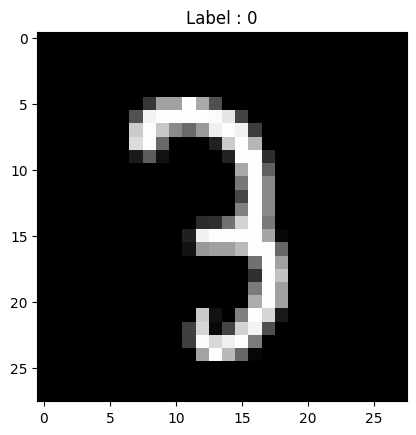

In [72]:
def image(a):
    a = np.random.randint(0, m)
    plt.imshow(x[:, a].reshape(28, 28), cmap='gray')
    plt.title("Label : {}".format(y[a]))
    plt.show()
#random image along with its label
img = image(0)


In [73]:
#one hot encoding
def one_hot(y):
    one_hot_y = np.zeros((10, y.size))
    for i in range(y.size):
        one_hot_y[y[i], i] = 1
    return one_hot_y
one_hot_y = one_hot(y)
one_hot_y.shape

(10, 28000)

In [74]:
#def parameters() :

class Parameters:
    def __init__(self):
        self.W1 = np.random.randn(10, 784)# -0.5 #0.01  # adding bias to the weights
        self.W2 = np.random.randn(10,10) #- 0.5#0.01
        self.b1 = np.zeros((10,m)) #- 0.5
        self.b2 = np.zeros((10, m)) #- 0.5  
        self.alpha  = 0.1    # learning rate
params = Parameters()
W1 = params.W1
W2 = params.W2
b1 = params.b1
b2 = params.b2
alpha = params.alpha
        

print(W1.shape, W2.shape, b1.shape, b2.shape)
x.shape, one_hot_y.shape

W1

(10, 784) (10, 10) (10, 28000) (10, 28000)


array([[-1.33221258e+00,  4.62250759e-01, -4.03715764e-01, ...,
         2.87024304e-01,  9.68236054e-02, -5.08201530e-01],
       [-3.41094706e-01, -5.08231084e-01,  5.53112117e-01, ...,
        -1.76042541e+00, -1.24648548e+00, -9.90627322e-04],
       [ 1.53079628e+00,  6.01791221e-01, -5.54570000e-01, ...,
         5.52340133e-01, -1.49064554e+00,  3.29127146e-01],
       ...,
       [ 7.45381183e-01, -1.88447805e+00, -8.05438606e-01, ...,
        -4.38303069e-01, -3.72469463e-02, -1.09716205e+00],
       [-2.39311447e-01, -3.40084914e-01,  6.34014098e-01, ...,
        -1.93498389e+00,  4.19386518e-01,  1.87518804e+00],
       [ 5.46111536e-01, -2.03055688e-01,  7.68287015e-02, ...,
        -5.18160798e-01, -5.71017918e-02, -7.93775799e-01]])

In [75]:
def RELU(L):
    return np.maximum(0, L)#

In [76]:
def softmax(x):
    x = x - np.max(x)  # Numerical stability
    softmax_output = np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)

In [77]:
def der_Relu(x):
    x[x<=0] = 0
    x[x>0] /= 1
    return x

In [78]:
def for_pass(W1, W2, b1, b2, x):
    L1 = np.dot(W1, x) + b1 #first layer
    A1 = RELU(L1) #activation function
    L2 = np.dot(W2, A1) + b2 #second layer
    A2 = softmax(L2) #activation function
    return L1, A1, L2, A2



L1, A1, L2, A2 = for_pass(W1, W2, b1, b2, x)


C:\Users\prana\AppData\Local\Temp\ipykernel_25988\2819944920.py:3: RuntimeWarning: invalid value encountered in divide
  softmax_output = np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)


In [79]:
def back_pass(L2, A2, one_hot_y, W2, A1, x, L1):
     #error in the second layer
    dL2 = A2 - one_hot_y  # error in the second layer
    dW2 = np.dot(dL2, A1.T)/m #gradient of the weights in the second layer
    db2 = np.sum(dL2, axis=1, keepdims=True)/m #gradient of the bias in the second layer
    dL1 = np.dot(W2.T, dL2) * der_Relu(L1) #error in the first layer
    dW1 = np.dot(dL1, x.T)/m #gradient of the weights in the first layer
    db1 = np.sum(dL1, axis=1, keepdims=True)/m #gradient of the bias in the first layer
    return dL2, dW2, db2, dL1, dW1, db1

In [80]:
def weight_update(W1, W2, b1, b2, dW1, dW2, db1, db2, alpha) :
    #alpha = 0.01
    W1 = W1 - alpha*dW1    #aplha is the learning rate
    W2 = W2 - alpha*dW2
    b1 = b1 - alpha*db1
    b2 = b2 - alpha*db2
    return W1, W2, b1, b2

In [81]:
def get_predictions(A2) :
    return np.argmax(A2, 0) #returns the index of the maximum value in the array

In [82]:
def compute_loss(A2, one_hot_y):
    m = one_hot_y.shape[1]  # Number of examples
    # Cross-entropy loss
    loss = -np.sum(one_hot_y * np.log(A2 + 1e-8)) / m  # Adding epsilon to avoid log(0)
    return loss

In [83]:
def get_accuracy(predictions, y):
    return (np.sum(predictions == y) / y.size ) * 100 # returns the accuracy of the model


Iteration 0: Loss = 18.089492827478505, Accuracy = 1.7714285714285714%
Iteration 200: Loss = -9.999999889225291e-09, Accuracy = 100.0%
Iteration 400: Loss = -9.999999889225291e-09, Accuracy = 100.0%
Iteration 600: Loss = -9.999999889225291e-09, Accuracy = 100.0%
Iteration 800: Loss = -9.999999889225291e-09, Accuracy = 100.0%


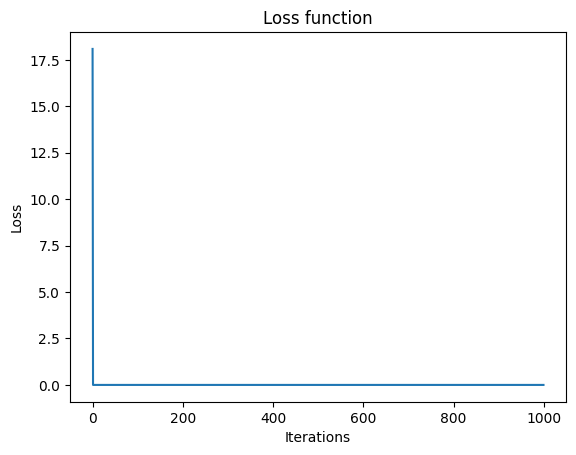

In [84]:
import cupy as cp


# Convert numpy arrays to cupy arrays
x_cp = cp.array(x)
one_hot_y_cp = cp.array(one_hot_y)
W1_cp = cp.array(W1)
W2_cp = cp.array(W2)
b1_cp = cp.array(b1)
b2_cp = cp.array(b2)

# Update functions to use cupy arrays
def for_pass_cp(W1, W2, b1, b2, x):
    L1 = cp.dot(W1, x) + b1
    A1 = cp.maximum(0, L1)  # RELU
    L2 = cp.dot(W2, A1) + b2
    A2 = cp.exp(L2 - cp.max(L2, axis=0, keepdims=True)) / cp.sum(cp.exp(L2 - cp.max(L2, axis=0, keepdims=True)), axis=0, keepdims=True)  # softmax
    return L1, A1, L2, A2

def back_pass_cp(L2, A2, one_hot_y, W2, A1, x, L1):
    dL2 = A2 - one_hot_y
    dW2 = cp.dot(dL2, A1.T) / m
    db2 = cp.sum(dL2, axis=1, keepdims=True) / m
    dL1 = cp.dot(W2.T, dL2) * (L1 > 0)
    dW1 = cp.dot(dL1, x.T) / m
    db1 = cp.sum(dL1, axis=1, keepdims=True) / m
    return dL2, dW2, db2, dL1, dW1, db1

def weight_update_cp(W1, W2, b1, b2, dW1, dW2, db1, db2, alpha):
    W1 -= alpha * dW1
    W2 -= alpha * dW2
    b1 -= alpha * db1
    b2 -= alpha * db2
    return W1, W2, b1, b2

def gradient_descent_cp(x, one_hot_y, alpha, iterations):
    W1 = cp.array(params.W1)
    W2 = cp.array(params.W2)
    b1 = cp.array(params.b1)
    b2 = cp.array(params.b2)
    losses = []
    for i in range(iterations):
        L1, A1, L2, A2 = for_pass_cp(W1, W2, b1, b2, x)
        dL2, dW2, db2, dL1, dW1, db1 = back_pass_cp(L2, A2, one_hot_y, W2, A1, x, L1)
        W1, W2, b1, b2 = weight_update_cp(W1, W2, b1, b2, dW1, dW2, db1, db2, alpha)
        loss = -cp.sum(one_hot_y * cp.log(A2 + 1e-8)) / m
        losses.append(cp.asnumpy(loss))
        if i % 200 == 0:
            predictions = cp.argmax(A2, axis=0)
            predictions_cpu = cp.asnumpy(predictions)
            accuracy = np.mean(predictions_cpu == y)
            print(f"Iteration {i}: Loss = {loss}, Accuracy = {accuracy * 100}%")
    return W1, W2, b1, b2, A2, losses

# Run gradient descent with cupy
W1_cp, W2_cp, b1_cp, b2_cp, A2_cp, losses_cp = gradient_descent_cp(x_cp, one_hot_y_cp, 0.01, 1000)

# Convert results back to numpy arrays
W1 = cp.asnumpy(W1_cp)
W2 = cp.asnumpy(W2_cp)
b1 = cp.asnumpy(b1_cp)
b2 = cp.asnumpy(b2_cp)
A2 = cp.asnumpy(A2_cp)

# Plot the loss
plt.plot(losses_cp)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss function')
plt.show()

In [87]:
test_data = pd.read_csv('test.csv')
test_data = np.array(test_data)
x_test = data[:, :].T #/255.0  # extracting the pixel value 
y_test = data[:, 0]   # extracting the labels in the first column


In [88]:
#testin the model   
def test_model(W1, W2, b1, b2, x_test, y_test):
    L1, A1, L2, A2 = for_pass(W1, W2, b1, b2, x)
    predictions = get_predictions(A2)
    accuracy = get_accuracy(predictions, y)
    return accuracy

In [89]:
# Test the model
accuracy = test_model(W1, W2, b1, b2, x_test, y_test)
print(f"Accuracy on test set = {accuracy}%")


Accuracy on test set = 100.0%


C:\Users\prana\AppData\Local\Temp\ipykernel_25988\2819944920.py:3: RuntimeWarning: invalid value encountered in divide
  softmax_output = np.exp(x) / np.sum(np.exp(x), axis=0, keepdims=True)


In [91]:
%pip install cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [92]:
import cv2

def identify_image(img_path):
    # Load image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # Resize to 28x28
    img = cv2.resize(img, (28, 28))
    # Flatten and reshape for the model
    img_array = img.flatten().reshape(784, 1)
    # Forward pass
    L1_temp, A1_temp, L2_temp, A2_temp = for_pass(W1, W2, b1, b2, img_array)
    prediction = get_predictions(A2_temp)
    print("Identified class:", prediction[0])

ModuleNotFoundError: No module named 'cv2'